# 1 Import

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score

In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [52]:
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
# IMPORT DATA AND CORRECT SPELLING OF ORIGINAL COLUMN HEADERS FOR CONSISTENCY
fraud = pd.read_csv('C:/Users/Delmafia91/Downloads/PredictFraudinFinancialPayment.csv')
fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


TEST IF THERE ANY MISSING VALUES IN DATAFRAME. IT TURNS OUT THERE ARE NO OBVIOUS MISSING VALUES BUT,
AS WE WILL SEE BELOW, THIS DOES NOT RULE OUT PROXIES BY A NUMERICAL VALUE LIKE 0

In [6]:
fraud.isnull().values.any()

False

# 2. Exploratory Data Analysis
In this section and until section 4, we wrangle with the data exclusively using Dataframe methods. This is the most succinct way to gain insights into the dataset. More elaborate visualizations follow in subsequent sections.

Which types of transactions are fraudulent?
We find that of the five types of transactions, fraud occurs only in two of them (see also kernels by Net, Philipp Schmidt and Ibe_Noriaki): 'TRANSFER' where money is sent to a customer / fraudster and 'CASH_OUT' where money is sent to a merchant who pays the customer / fraudster in cash. Remarkably, the number of fraudulent TRANSFERs almost equals the number of fraudulent CASH_OUTs (see the right half of the plot in section 5.1). These observations appear, at first, to bear out the description provided on Kaggle for the modus operandi of fraudulent transactions in this dataset, namely, fraud is committed by first transferring out funds to another account which subsequently cashes it out. We will return to this issue later in section 

In [7]:
print('\n The types of fraudulent transactions are {}'.format(\
list(fraud.loc[fraud.isFraud == 1].type.drop_duplicates().values)))


 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']


In [8]:
fraudFraudTransfer = fraud.loc[(fraud.isFraud == 1) & (fraud.type == 'TRANSFER')]
fraudFraudCashout = fraud.loc[(fraud.isFraud == 1) & (fraud.type == 'CASH_OUT')]

In [9]:
print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(fraudFraudTransfer))) # 4097

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(fraudFraudCashout))) # 4116


 The number of fraudulent TRANSFERs = 564

 The number of fraudulent CASH_OUTs = 578


What determines whether the feature isFlaggeFraud gets set or not?
It turns out that the origin of isFlaggedFraud is unclear, contrasting with the description provided. The 16 entries (out of 6 million) where the isFlaggedFraud feature is set do not seem to correlate with any explanatory variable. The data is described as isFlaggedFraud being set when an attempt is made to 'TRANSFER' an 'amount' greater than 200,000. In fact, as shown below, isFlaggedFraud can remain not set despite this condition being met.

In [10]:
print('\nThe type of transactions in which isFlaggedFraud is set: \
{}'.format(list(fraud.loc[fraud.isFlaggedFraud == 1].type.drop_duplicates()))) 
                                    
fraudTransfer = fraud.loc[fraud.type == 'TRANSFER']
fraudFlagged = fraud.loc[fraud.isFlaggedFraud == 1]
fraudNotFlagged = fraud.loc[fraud.isFlaggedFraud == 0]

print('\nMin amount transacted when isFlaggedFraud is set= {}'\
                                  .format(fraudFlagged.amount.min()))

print('\nMax amount transacted in a TRANSFER where isFlaggedFraud is not set=\
 {}'.format(fraudTransfer.loc[fraudTransfer.isFlaggedFraud == 0].amount.max())) 


The type of transactions in which isFlaggedFraud is set: []

Min amount transacted when isFlaggedFraud is set= nan

Max amount transacted in a TRANSFER where isFlaggedFraud is not set= 10000000.0


Can oldBalanceDest and newBalanceDest determine isFlaggedFraud being set? The old is identical to the new balance in the origin and destination accounts, for every TRANSFER where isFlaggedFraud is set. This is presumably because the transaction is halted [4]. Interestingly, oldBalanceDest = 0 in every such transaction. However, as shown below, since isFlaggedFraud can remain not set in TRANSFERS where oldBalanceDest and newBalanceDest can both be 0, these conditions do not determine the state of isFlaggedFraud.

In [11]:
fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [12]:
print('\nThe number of TRANSFERs where isFlaggedFraud = 0, yet oldbalanceDest = 0 and\
 newbalanceDest = 0: {}'.\
format(len(fraudTransfer.loc[(fraudTransfer.isFlaggedFraud == 0) & \
(fraudTransfer.oldbalanceDest == 0) & (fraudTransfer.newbalanceDest == 0)]))) # 4158


The number of TRANSFERs where isFlaggedFraud = 0, yet oldbalanceDest = 0 and newbalanceDest = 0: 618


isFlaggedFraud being set cannot be thresholded on oldBalanceOrig since the corresponding range of values overlaps with that for TRANSFERs where isFlaggedFraud is not set (see below). Note that we do not need to consider newBalanceOrig since it is updated only after the transaction, whereas isFlaggedFraud would be set before the transaction takes place.

In [13]:
fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [14]:
print('\nMin, Max of oldbalanceOrg for isFlaggedFraud = 0 TRANSFERs where \
oldbalanceOrg = \
newbalanceOrig: {}'.format(\
[fraudTransfer.loc[(fraudTransfer.isFlaggedFraud == 0) & (fraudTransfer.oldbalanceOrg \
== fraudTransfer.newbalanceOrig)].oldbalanceOrg.min(), \
round(fraudTransfer.loc[(fraudTransfer.isFlaggedFraud == 0) & (fraudTransfer.oldbalanceOrg \
               == fraudTransfer.newbalanceOrig)].oldbalanceOrg.max())]))


Min, Max of oldbalanceOrg for isFlaggedFraud = 0 TRANSFERs where oldbalanceOrg = newbalanceOrig: [0.0, 575668]


Can isFlaggedFraud be set based on seeing a customer transacting more than once? Note that duplicate customer names don't exist within transactions where isFlaggedFraud is set, but duplicate customer names exist within transactions where isFlaggedFraud is not set. It turns out that originators of transactions that have isFlaggedFraud set have transacted only once. Very few destination accounts of transactions that have isFlaggedFraud set have transacted more than once.

In [15]:
fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [16]:
print('\nHave originators of transactions flagged as fraud transacted more than \
once? {}'\
.format((fraudFlagged.nameOrig.isin(pd.concat([fraudNotFlagged.nameOrig, \
                                    fraudNotFlagged.nameDest]))).any())) # False

print('\nHave destinations for transactions flagged as fraud initiated\
 other transactions? \
{}'.format((fraudFlagged.nameDest.isin(fraudNotFlagged.nameOrig)).any())) # False

# Since only 2 destination accounts of 16 that have 'isFlaggedFraud' set have been
# destination accounts more than once,
# clearly 'isFlaggedFraud' being set is independent of whether a 
# destination account has been used before or not

print('\nHow many destination accounts of transactions flagged as fraud have been \
destination accounts more than once?: {}'\
.format(sum(fraudFlagged.nameDest.isin(fraudNotFlagged.nameDest)))) # 2


Have originators of transactions flagged as fraud transacted more than once? False

Have destinations for transactions flagged as fraud initiated other transactions? False

How many destination accounts of transactions flagged as fraud have been destination accounts more than once?: 0


It can be easily seen that transactions with isFlaggedFraud set occur at all values of step, similar to the complementary set of transactions. Thus isFlaggedFraud does not correlate with step either and is therefore seemingly unrelated to any explanatory variable or feature in the data

Conclusion: Although isFraud is always set when isFlaggedFraud is set, since isFlaggedFraud is set just 16 times in a seemingly meaningless way, we can treat this feature as insignificant and discard it in the dataset without loosing information.

It was stated [5] that CASH_IN involves being paid by a merchant (whose name is prefixed by 'M'). However, as shown below, the present data does not have merchants making CASH_IN transactions to customers.

In [17]:
print('\nAre there any merchants among originator accounts for CASH_IN \
transactions? {}'.format(\
(fraud.loc[fraud.type == 'CASH_IN'].nameOrig.str.contains('M')).any())) # False


Are there any merchants among originator accounts for CASH_IN transactions? False


Similarly, it was stated that CASH_OUT involves paying a merchant. However, for CASH_OUT transactions there are no merchants among the destination accounts.

In [18]:
print('\nAre there any merchants among destination accounts for CASH_OUT \
transactions? {}'.format(\
(fraud.loc[fraud.type == 'CASH_OUT'].nameDest.str.contains('M')).any())) # False


Are there any merchants among destination accounts for CASH_OUT transactions? False


In fact, there are no merchants among any originator accounts. Merchants are only present in destination accounts for all PAYMENTS.

In [19]:
print('\nAre there merchants among any originator accounts? {}'.format(\
      fraud.nameOrig.str.contains('M').any())) # False

print('\nAre there any transactions having merchants among destination accounts\
 other than the PAYMENT type? {}'.format(\
(fraud.loc[fraud.nameDest.str.contains('M')].type != 'PAYMENT').any())) # False


Are there merchants among any originator accounts? False

Are there any transactions having merchants among destination accounts other than the PAYMENT type? False


Conclusion: Among the account labels nameOrig and nameDest, for all transactions, the merchant prefix of 'M' occurs in an unexpected way.

From the data description, the modus operandi for committing fraud involves first making a TRANSFER to a (fraudulent) account which in turn conducts a CASH_OUT. CASH_OUT involves transacting with a merchant who pays out cash. Thus, within this two-step process, the fraudulent account would be both, the destination in a TRANSFER and the originator in a CASH_OUT. However, the data shows below that there are no such common accounts among fraudulent transactions. Thus, the data is not imprinted with the expected modus-operandi.

In [20]:
print('\nWithin fraudulent transactions, are there destinations for TRANSFERS \
that are also originators for CASH_OUTs? {}'.format(\
(fraudFraudTransfer.nameDest.isin(fraudFraudCashout.nameOrig)).any())) # False
fraudNotFraud = fraud.loc[fraud.isFraud == 0]


Within fraudulent transactions, are there destinations for TRANSFERS that are also originators for CASH_OUTs? False


Could destination accounts for fraudulent TRANSFERs originate CASHOUTs that are not detected and are labeled as genuine? It turns out there are 3 such accounts.

In [21]:
print('\nFraudulent TRANSFERs whose destination accounts are originators of \
genuine CASH_OUTs: \n\n{}'.format(fraudFraudTransfer.loc[fraudFraudTransfer.nameDest.\
isin(fraudNotFraud.loc[fraudNotFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates())]))


Fraudulent TRANSFERs whose destination accounts are originators of genuine CASH_OUTs: 

Empty DataFrame
Columns: [step, type, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest, isFraud, isFlaggedFraud]
Index: []


In [22]:
print('\nFraudulent TRANSFER to C423543548 occured at step = 486 whereas \
genuine CASH_OUT from this account occured earlier at step = {}'.format(\
fraudNotFraud.loc[(fraudNotFraud.type == 'CASH_OUT') & (fraudNotFraud.nameOrig == \
                           'C423543548')].step.values)) 


Fraudulent TRANSFER to C423543548 occured at step = 486 whereas genuine CASH_OUT from this account occured earlier at step = []


# 3 Data Cleaning

In [23]:
X = fraud.loc[(fraud.type == 'TRANSFER') | (fraud.type == 'CASH_OUT')]
randomState = 5
np.random.seed(randomState)

Y = X['isFraud']
del X['isFraud']

X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int)
            

# 3.1
The data has several transactions with zero balances in the destination account both before and after a non-zero amount is transacted. The fraction of such transactions, where zero likely denotes a missing value, is much larger in fraudulent (50%) compared to genuine transactions (0.06%).

In [24]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]
print('\nThe fraction of fraudulent transactions with \'oldbalanceDest\' = \
\'newbalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(Xfraud.loc[(Xfraud.oldbalanceDest == 0) & \
(Xfraud.newbalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldbalanceDest == 0) & \
(XnonFraud.newbalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))


The fraction of fraudulent transactions with 'oldbalanceDest' = 'newbalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4754816112084063

The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.002308100999015791


Since the destination account balances being zero is a strong indicator of fraud, we do not impute the account balance (before the transaction is made) with a statistic or from a distribution with a subsequent adjustment for the amount transacted. Doing so would mask this indicator of fraud and make fraudulent transactions appear genuine. Instead, below we replace the value of 0 with -1 which will be more useful to a suitable machine-learning (ML) algorithm detecting fraud.

In [25]:
X.loc[(X.oldbalanceDest == 0) & (X.newbalanceDest == 0) & (X.amount != 0), \
      ['oldbalanceDest', 'newbalanceDest']] = - 1

The data also has several transactions with zero balances in the originating account both before and after a non-zero amount is transacted. In this case, the fraction of such transactions is much smaller in fraudulent (0.3%) compared to genuine transactions (47%). Once again, from similar reasoning as above, instead of imputing a numerical value we replace the value of 0 with a null value.

In [26]:
X.loc[(X.oldbalanceOrg == 0) & (X.newbalanceOrig == 0) & (X.amount != 0), \
      ['oldbalanceOrg', 'newbalanceOrig']] = np.nan

# 4
Motivated by the possibility of zero-balances serving to differentiate between fraudulent and genuine transactions, we take the data-imputation of section 3.1 a step further and create 2 new features (columns) recording errors in the originating and destination accounts for each transaction. These new features turn out to be important in obtaining the best performance from the ML algorithm that we will finally use.

In [27]:
X['errorBalanceOrig'] = X.newbalanceOrig + X.amount - X.oldbalanceOrg
X['errorBalanceDest'] = X.oldbalanceDest + X.amount - X.newbalanceDest

# 5 Visualization

The best way of confirming that the data contains enough information so that a ML algorithm can make strong predictions, is to try and directly visualize the differences between fraudulent and genuine transactions. Motivated by this principle, I visualize these differences in several ways in the plots below.

In [28]:
limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

# 5.1
The plot below shows how the fraudulent and genuine transactions yield different fingerprints when their dispersion is viewed over time. It is clear that fradulent transactions are more homogenously distributed over time compared to genuine transactions. Also apparent is that CASH-OUTs outnumber TRANSFERs in genuine transactions, in contrast to a balanced distribution between them in fraudulent transactions. Note that the the width of each 'fingerprint' is set by the 'jitter' parameter in the plotStrip function above which attempts to separate out and plot transactions occuring at the same time with different abscissae.



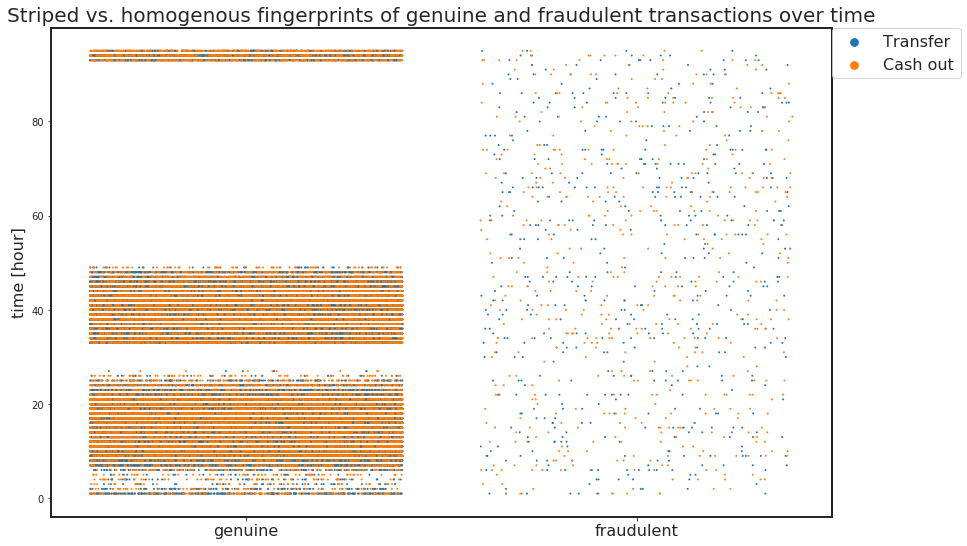

In [29]:
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time [hour]', size = 16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent \
transactions over time', size = 20);

# 5.3
The two plots below shows that although the presence of fraud in a transaction can be discerned by the original amount feature, the new errorBalanceDest feature is more effective at making a distinction.

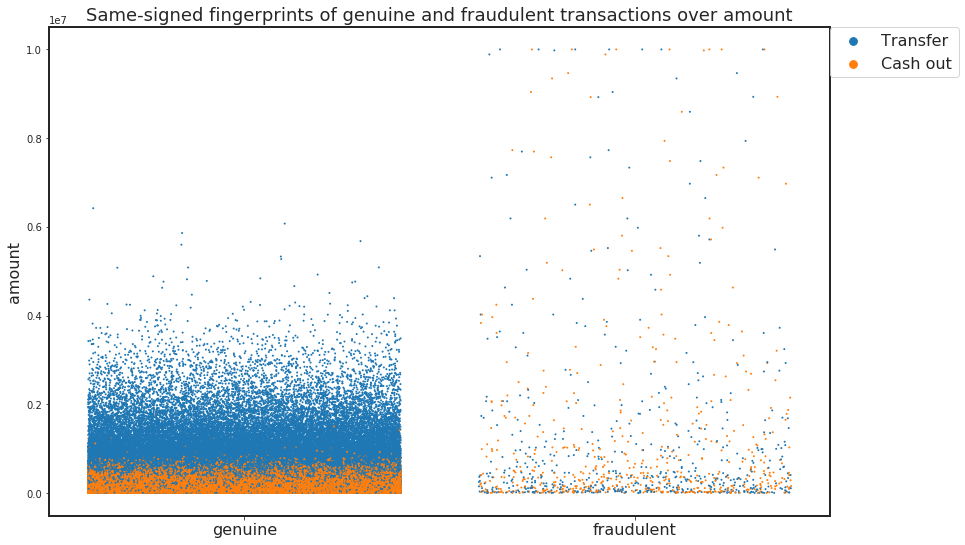

In [30]:
limit = len(X)
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Same-signed fingerprints of genuine \
and fraudulent transactions over amount', size = 18);

# 5.2
Dispersion over error in balance in destination accounts


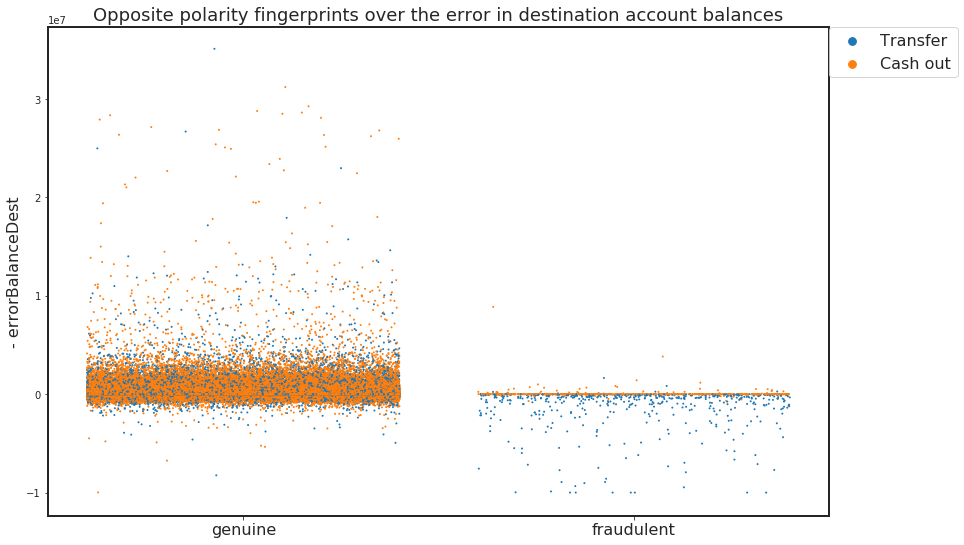

In [31]:
limit = len(X)
ax = plotStrip(Y[:limit], - X.errorBalanceDest[:limit], X.type[:limit], \
              figsize = (14, 9))
ax.set_ylabel('- errorBalanceDest', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in \
destination account balances', size = 18);

Section 5.4
The 3D plot below distinguishes best between fraud and non-fraud data by using both of the engineered error-based features. Clearly, the original step feature is ineffective in seperating out fraud. Note the striped nature of the genuine data vs time which was aniticipated from the figure in section 5.1.

C:\Users\Delmafia91\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
C:\Users\Delmafia91\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
C:\Users\Delmafia91\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
C:\Users\Delmafia91\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
C:\Users\Delmafia91\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.le

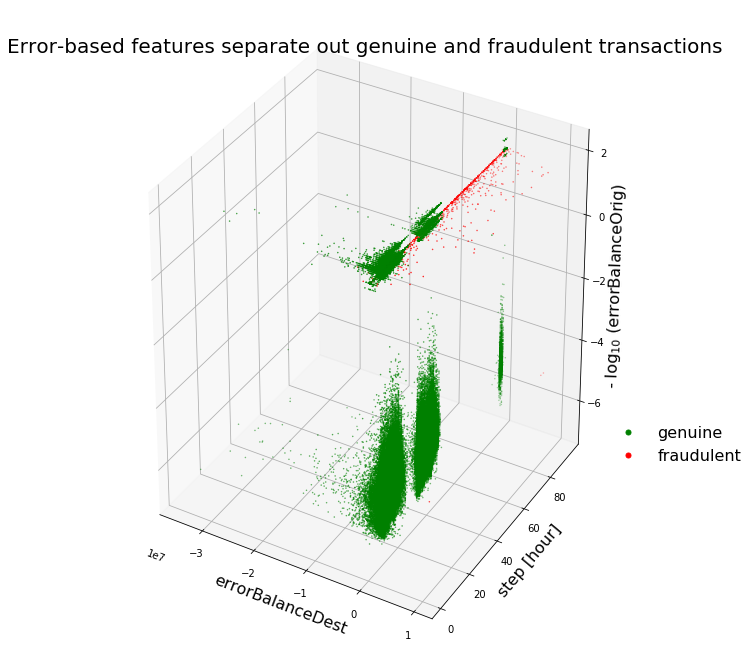

In [32]:
x = 'errorBalanceDest'
y = 'step'
z = 'errorBalanceOrig'
zOffset = 0.02
limit = len(X)

sns.reset_orig() # prevent seaborn from over-riding mplot3d defaults

fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X.loc[Y == 0, x][:limit], X.loc[Y == 0, y][:limit], \
  -np.log10(X.loc[Y == 0, z][:limit] + zOffset), c = 'g', marker = '.', \
  s = 1, label = 'genuine')
    
ax.scatter(X.loc[Y == 1, x][:limit], X.loc[Y == 1, y][:limit], \
  -np.log10(X.loc[Y == 1, z][:limit] + zOffset), c = 'r', marker = '.', \
  s = 1, label = 'fraudulent')

ax.set_xlabel(x, size = 16); 
ax.set_ylabel(y + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z + ')', size = 16)
ax.set_title('Error-based features separate out genuine and fraudulent \
transactions', size = 20)

plt.axis('tight')
ax.grid(1)

noFraudMarker = mlines.Line2D([], [], linewidth = 0, color='g', marker='.',
                          markersize = 10, label='genuine')
fraudMarker = mlines.Line2D([], [], linewidth = 0, color='r', marker='.',
                          markersize = 10, label='fraudulent')

plt.legend(handles = [noFraudMarker, fraudMarker], \
           bbox_to_anchor = (1.20, 0.38 ), frameon = False, prop={'size': 16});

# 5.5  
Fingerprints of genuine and fraudulent transactions
Smoking gun and comprehensive evidence embedded in the dataset of the difference between fraudulent and genuine transactions is obtained by examining their respective correlations in the heatmaps below.

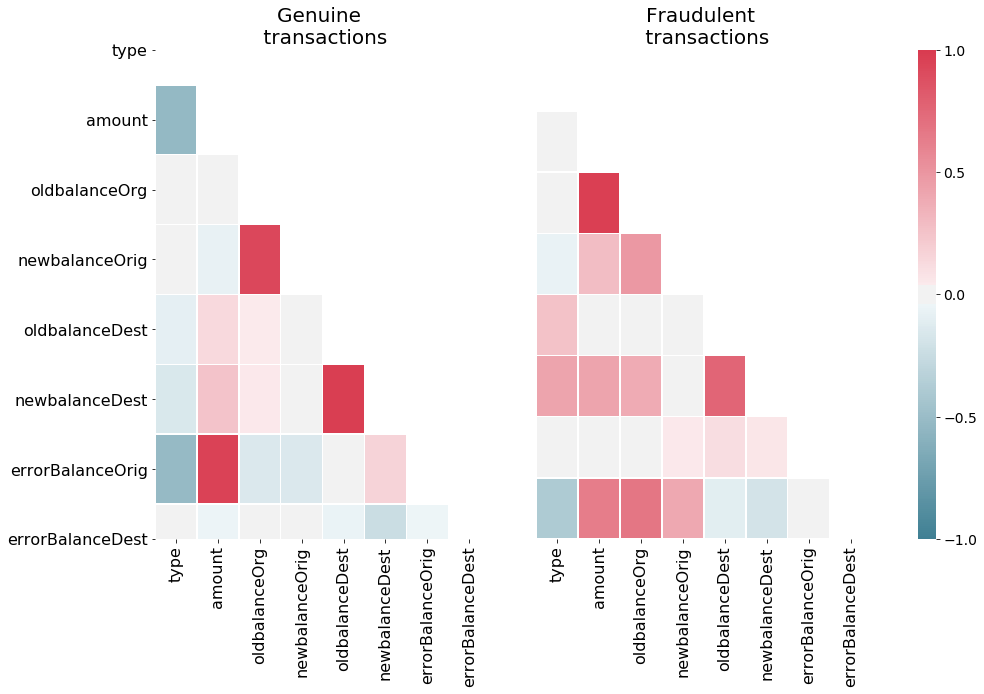

In [33]:
Xfraud = X.loc[Y == 1] # update Xfraud & XnonFraud with cleaned data
XnonFraud = X.loc[Y == 0]
                  
correlationNonFraud = XnonFraud.loc[:, X.columns != 'step'].corr()
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True

grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, \
                                     figsize = (14, 9))

cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax1 =sns.heatmap(correlationNonFraud, ax = ax1, vmin = -1, vmax = 1, \
    cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = False)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 16); 
ax1.set_yticklabels(ax1.get_yticklabels(), size = 16); 
ax1.set_title('Genuine \n transactions', size = 20)

correlationFraud = Xfraud.loc[:, X.columns != 'step'].corr()
ax2 = sns.heatmap(correlationFraud, vmin = -1, vmax = 1, cmap = cmap, \
 ax = ax2, square = False, linewidths = 0.5, mask = mask, yticklabels = False, \
    cbar_ax = cbar_ax, cbar_kws={'orientation': 'vertical', \
                                 'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size = 16); 
ax2.set_title('Fraudulent \n transactions', size = 20);

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 14);

# 6. Machine Learning to Detect Fraud

Since we have evidence of fraudulent transactions that are clearly
detectable, the remaining obstacle of training a machine learning
model is imbalanced 

In [34]:
print('skew = {}'.format(len(Xfraud) / float(len(X))))

skew = 0.002480484107090883


Now we are going to do a "CV", meaning Cross-Validation to apply
a machine learning algorithm to this imbalanced data.
How we are selecting a ML algorith? 
A first approach to deal with imbalanced data is to balance it by discarding the majority class before applying an ML algorithm. The disadvantage of undersampling is that a model trained in this way will not perform well on real-world skewed test data since almost all the information was discarded. A better approach might be to oversample the minority class, say by the synthetic minority oversampling technique (SMOTE) contained in the 'imblearn' library. Motivated by this, I tried a variety of anomaly-detection and supervised learning approaches. I find, however, that the best result is obtained on the original dataset by using a ML algorithm based on ensembles of decision trees that intrinsically performs well on imbalanced data. Such algorithms not only allow for constructing a model that can cope with the missing values in our data, but they naturally allow for speedup via parallel-processing. Among these algorithms, the extreme gradient-boosted (XGBoost) algorithm used below slightly outperforms random-forest. Finally, XGBoost, like several other ML algorithms, allows for weighting the positive class more compared to the negative class --- a setting that also allows to account for the skew in the data.

When it comes to cross-validation, generally we do a 70:30 ratio
where the 30% is for testing and the 70% for the training of the 
algorithm.

In [35]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.3,
                                               random_state = randomState)

In [36]:
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_dept = 3, scale_pos_weight = weights, n_jobs = 4)
probabilities = clf.fit(trainX, trainY).predict_proba(testX)
print('AUPRC = {}'.format(average_precision_score(testY, 
                                probabilities[:, 1])))

AUPRC = 0.9809739186058419


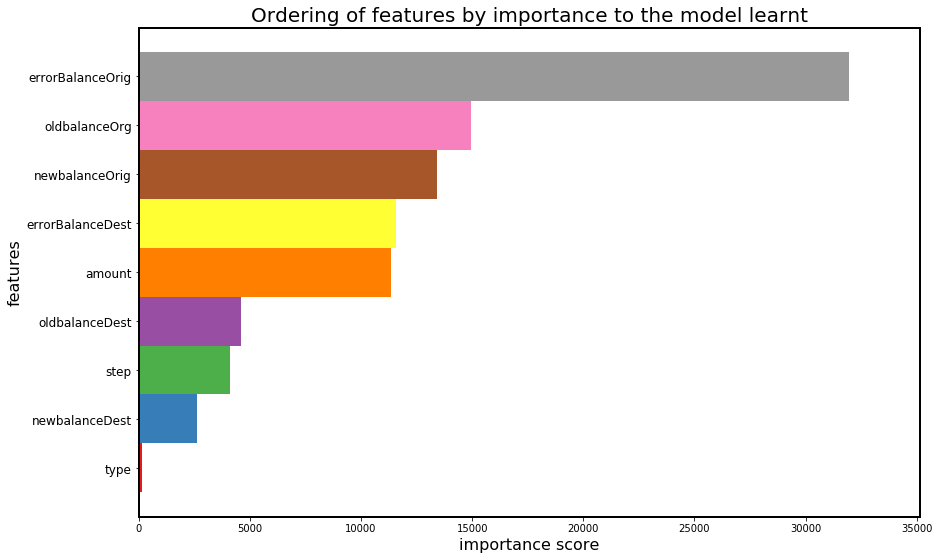

In [37]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)
colours = plt.cm.Set1(np.linspace(0, 1, 9))
ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                    show_values = False, importance_type = 'cover', \
                    ax = ax);
for axis in ['top', 'bottom', 'left','right']:
    ax.spines[axis].set_linewidth(2)

ax.set_xlabel('importance score', size = 16)
ax.set_ylabel('features', size = 16)
ax.set_yticklabels(ax.get_yticklabels(), size = 12)
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

The figure above shows that the new feature 'errorbalanceOrig' 
we created is the most relevant feature for the model. The features
are ordered based on the number of samples affected by splits on 
these features